In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
from matplotlib_venn import venn3
from pandas.plotting import register_matplotlib_converters; register_matplotlib_converters()

### Shared viewers for multiple channels

In [2]:
def intersection_calc(input_arr, columns=None, symmetric=False):
    '''
    input_arr should be an arr in which arr[i, j] is the size of the union of set i and set j for i <= j.
    The array can be all zeros below the diagonal to avoid duplication,
    for instance [[10, 5, 4], [0, 15, 9], [0, 0, 10]] would be an acceptable input.
    '''
    assert type(input_arr) in [list, np.ndarray, np.array], "Incorrect format"
    input_arr = np.array(input_arr)
    assert input_arr.ndim == 2, f"Incorrect number of dimensions: Should have 2, found {input_arr.ndim}"
    assert input_arr.shape[0] == input_arr.shape[1], f"Array should be square: Found shape {input_arr.shape}"
    
    # Calculates the output array, which will be of the same format as the input array, but
    # the (i, j)th element will be the intersection of set i and set j
    output_arr = np.zeros(shape=input_arr.shape)
    for i in range(input_arr.shape[0]):
        for j in range(i, input_arr.shape[1]):
            if i==j:
                output_arr[i, j] = input_arr[i, j]
            else:
                output_arr[i, j] = input_arr[i, i] + input_arr[j, j] - input_arr[i, j]
                
    if symmetric:
        for i in range(input_arr.shape[0]):
            for j in range(0, i):
                output_arr[i, j] = output_arr[j, i]
                
    if columns:
        return pd.DataFrame(output_arr.astype(int), index=columns, columns=columns)
    return output_arr.astype(int)


def make_array_symmetric(input_arr):
    arr = input_arr.copy()
    
    for i in range(1, arr.shape[0]):
        for j in range(0, i):
            arr[i, j] = arr[j, i]
    return arr
    

def intersection_calc_3d(input_arr):
    return np.array([intersection_calc(input_arr[a]) for a in range(input_arr.shape[0])])

def channel_percentages(df, channel_name):
    num = df[channel_name]
    den = num[channel_name]
    return pd.DataFrame(round(100*num/den, 2))

def format_csv_of_string(csv_loc, output_as_arr=False):
    df = pd.read_csv(csv_loc, sep=', ', engine='python')
    for col in df.columns:
        df[col] = df[col].apply(lambda a: int(a.replace('"', '').replace('“', '').replace('”', '').replace(',', '')) if type(a) == str else a)

    df.columns = [col_name.replace('"', '').replace('“', '').replace('”', '') for col_name in df.columns]
    
    if output_as_arr:
        df_vals = df.values
        arr = np.zeros((len(df.values), 2, 2))
        arr[:, 0, 0] = [8 for _ in range(len(arr[:, 0, 0]))]
        arr[:, 0, 0] = df[df.columns[1]]
        arr[:, 0, 1] = df[df.columns[0]]
        arr[:, 1, 1] = df[df.columns[2]]
        return arr
    
    return df

### Venn diagram

In [3]:
# Simple function to take data copied from google sheets and convert it to a numpy arr
# Input should be directly copied, surrounded by triple quotes (''' ...''')
def sheets_clipboard_to_array(copied_str):
    arr = copied_str.split('\n')
    arr = [[int(i_1.replace(',', '')) for i_1 in l_1.split('\t')] for l_1 in a_1]
    return np.array(arr)


# Function to calculate the size of the intersection of up to three sets, using the single, double and triple union sizes
def all_intersection_only_calc(double_union_arr, all_union_num):
    size = len(double_union_arr)
    return (sum([double_union_arr[i, i] for i in range(size)])
    - sum([double_union_arr[i, i-1] for i in range(size)]) + all_union_num)


def format_list_and_arr(union_arr_in, channels_list_in):
    # Making copies so that the original list/array are not modified
    channels_list = channels_list_in.copy()
    union_arr = union_arr_in.copy()
    
    # Padding the data appropriately if there are just 2 sets
    assert ((union_arr.shape[0] == union_arr.shape[1]) and (union_arr.shape[0] in [2, 3])
                and (len(channels_list)-union_arr.shape[0] in [0, -1])); "Please check the shape and size of input data."

    if union_arr.shape[0] == 2:
        union_arr = np.pad(union_arr, ((0, 1), (0, 1)), 'constant', constant_values=0)
    
    if len(channels_list) == 2:
        channels_list.append("")
        
    return union_arr, channels_list
    

def all_intersection_output(union_arr_in, all_union_num, channels_list):
    union_arr, channels_list_copy = format_list_and_arr(union_arr_in, channels_list)

    # Calculating the intersection of all channels
    all_intersection_num = all_intersection_only_calc(union_arr, all_union_num)
    
    # Calculating the intersection array
    intersection_arr = intersection_calc(union_arr, channels_list, True).values
    # Converting in to a dataframe for debugging/viewing, if necessary
    all_intersection_df = pd.DataFrame(intersection_arr, columns = channels_list_copy, index = channels_list_copy)
    
    double_intersection_values = [((all_intersection_df - all_intersection_num).values)[i-1, i] for i in [1, 2, 0]]
    double_intersection_keys = [f"{channels_list_copy[c[0]]} and {channels_list_copy[c[1]]} intersection only"
                                for c in [(i%3, (i+1)%3) for i in range(3)]]
    double_intersection_dict = {}
    
    for i in range(3):
        double_intersection_dict[double_intersection_keys[i]] = double_intersection_values[i]
        
    channel_only_dict = {}
    for channel_ind in range(len(channels_list_copy)):
        channel_only = (intersection_arr[channel_ind, channel_ind]
                        - sum([intersection_arr[channel_ind, i] for i in range(len(channels_list_copy)) if i != channel_ind])
                        + all_intersection_num
                       )
        channel_only_dict[channels_list_copy[channel_ind]] = channel_only
    channels_only_list = list(channel_only_dict.values())    
    double_intersection_list = list(double_intersection_dict.values())
    
    return (channels_only_list[0], channels_only_list[1], double_intersection_list[0],
           channels_only_list[2],
            double_intersection_list[2],
            double_intersection_list[1],
           all_intersection_num)


def plot_venn(subsets, channels_list, title=None, colours=('r', 'g', 'b')):
    if len(channels_list) == 2:
        channels_list.append("")
        channels_list[1], channels_list[2] = channels_list[2], channels_list[1]

    fig, ax = plt.subplots(1, 1, figsize=(18,12))
    venn3(subsets = subsets,
          set_labels = channels_list,
          ax = ax,
         set_colors=colours)
    ax.set_title(title, size=22)
    plt.show()
    
def intersection_and_plot(union_arr_in, all_union_num, channels_list, title=None, colours=('r', 'g', 'b'), return_subsets=False):
    subsets = all_intersection_output(union_arr_in, all_union_num, channels_list)
    plot_venn(subsets, channels_list, title, colours=colours)
    if return_subsets:
        return subsets

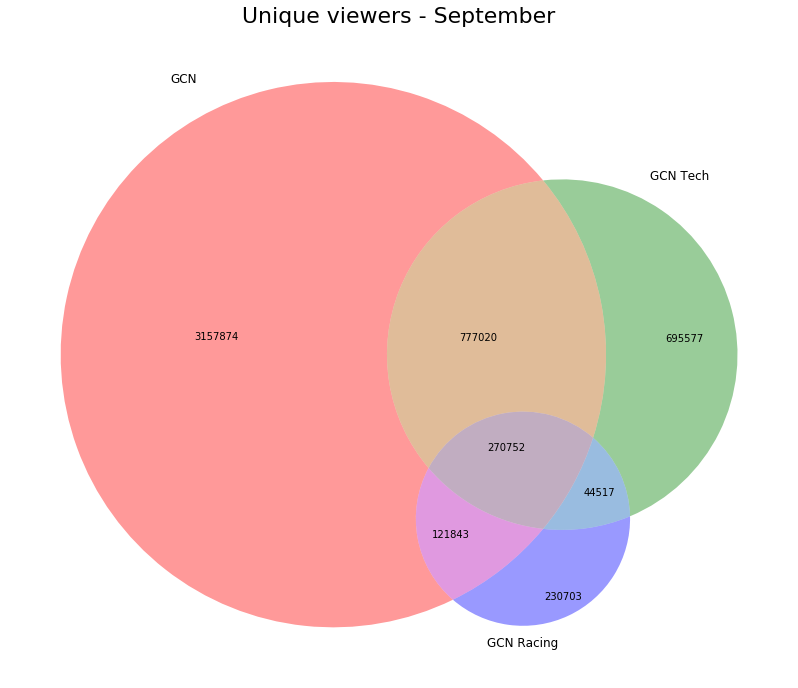

In [4]:
channels = ["GCN", "GCN Tech", "GCN Racing"]
title = "Unique viewers - September"
union_arr = make_array_symmetric(np.array([[4327489, 5067583, 4602709],
                                           [0, 1787866, 2140412],
                                           [0, 0, 667815]]))
triple_union_num = 5298286
    
subsets = intersection_and_plot(union_arr, triple_union_num, channels, title, return_subsets=True)

### Table output of venn diagram

In [5]:
def table_output(channels, subsets):

    list_0 = [0, 2, 4, 6]
    list_1 = [1, 2, 5, 6]
    list_2 = [3, 4, 5, 6]
    
    for channel_num, channel_list in enumerate([list_0, list_1, list_2]):
        
        remaining_channels = [i for i in range(3) if i != channel_num]
        
        channel_total = sum([subsets[i] for i in channel_list])
        
        channel_df = pd.DataFrame(
                                    {channels[channel_num]: [subsets[i]/channel_total for i in channel_list]},
                                    index = [f"{channels[channel_num]} only",
                                            f"Also watched {channels[remaining_channels[0]]}",
                                            f"Also watched {channels[remaining_channels[1]]}",
                                            f"Also watched {channels[remaining_channels[0]]} and {channels[remaining_channels[1]]}"]
                                   )
        print(channel_df, "\n")
    

table_output(channels, subsets)

                                           GCN
GCN only                              0.729724
Also watched GCN Tech                 0.179554
Also watched GCN Racing               0.028156
Also watched GCN Tech and GCN Racing  0.062566 

                                 GCN Tech
GCN Tech only                    0.389054
Also watched GCN                 0.434608
Also watched GCN Racing          0.024900
Also watched GCN and GCN Racing  0.151439 

                               GCN Racing
GCN Racing only                  0.345459
Also watched GCN                 0.182450
Also watched GCN Tech            0.066661
Also watched GCN and GCN Tech    0.405430 



### Shared viewers over time

In [6]:
def time_series_plot(arr, name_1, name_2, start_year, start_month, end_year, end_month):
    fig, ax = plt.subplots(figsize=(18, 12))
    matplotlib.rcParams.update({'font.size': 16})
    
    x = [f"{y}/{str(m).zfill(2)}" for y in range(start_year, end_year+1)
                        for m in range(1, 13)
                        if not ((y == start_year and m < start_month) or (y == end_year and m > end_month))]
    y = 100*intersection_calc_3d(arr)[:, 0, 1] / arr[:, 1, 1]
    x, y = np.array(x), np.array(y)
    assert len(x) == len(y), f"""Inconsistent dates and data: got dates of length {len(x)} months, and data of length {len(y)}."""

    # Linear regression
    x_reg = np.arange(len(x)).reshape(-1, 1)
    reg = LinearRegression().fit(x_reg, y)
    reg_y = reg.predict(x_reg)
    
    # Plotting
    ax.plot(x, reg_y, alpha=0.3, color='grey', linewidth=4)
    ax.plot(x, y, color='red')
    ax.set_title(f'Viewers of {name_2} that also watch {name_1} (%)', pad=20)
    ax.set_xlabel("Month", labelpad=15)
    ax.set_ylabel("Viewers %", labelpad=10)
    plt.xticks(rotation=45)
    plt.show()
    
    return pd.DataFrame({'Month': x, f'Viewers % ({name_2})': y})

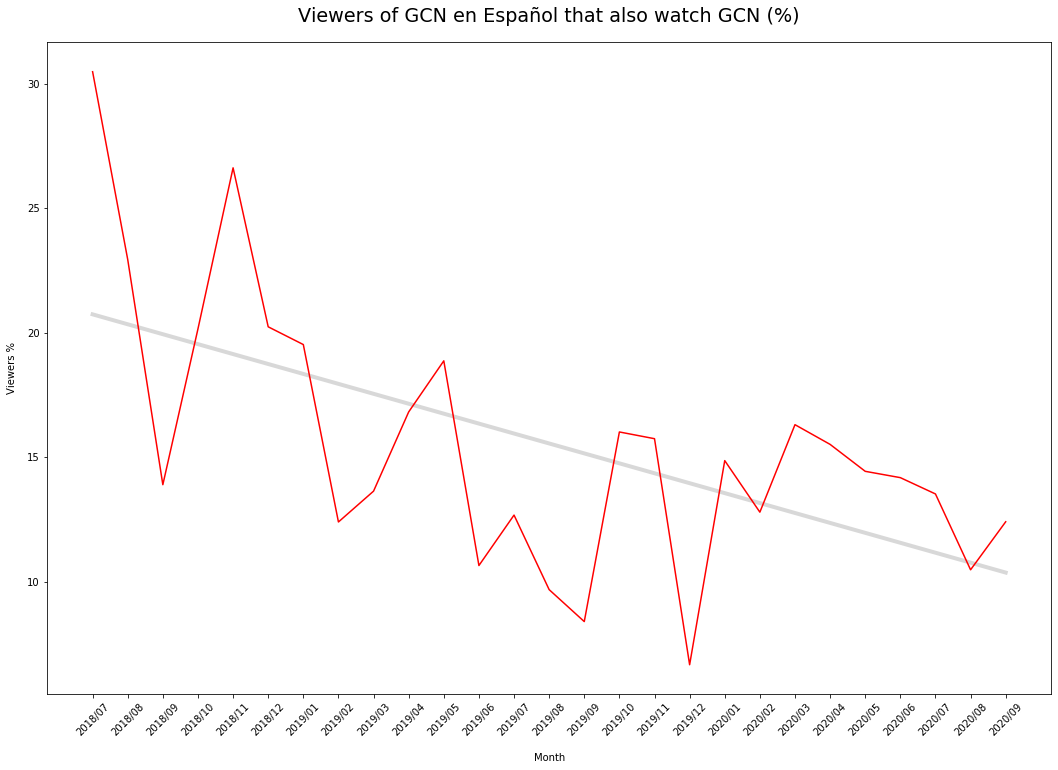

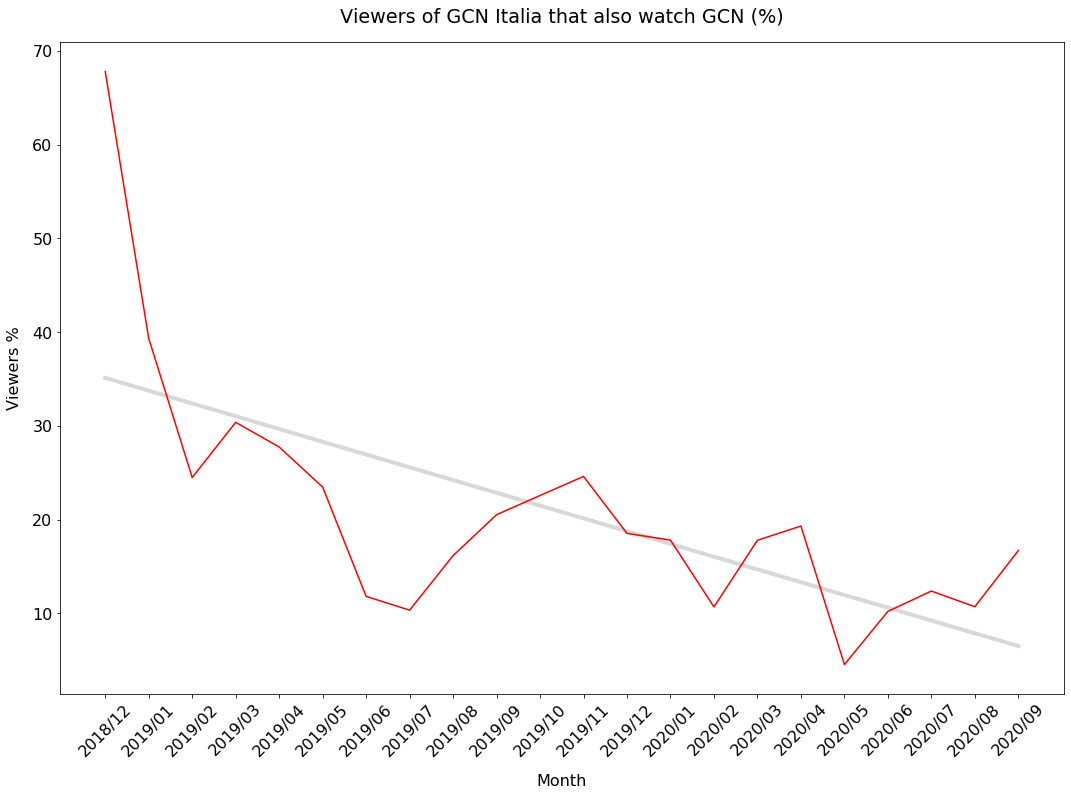

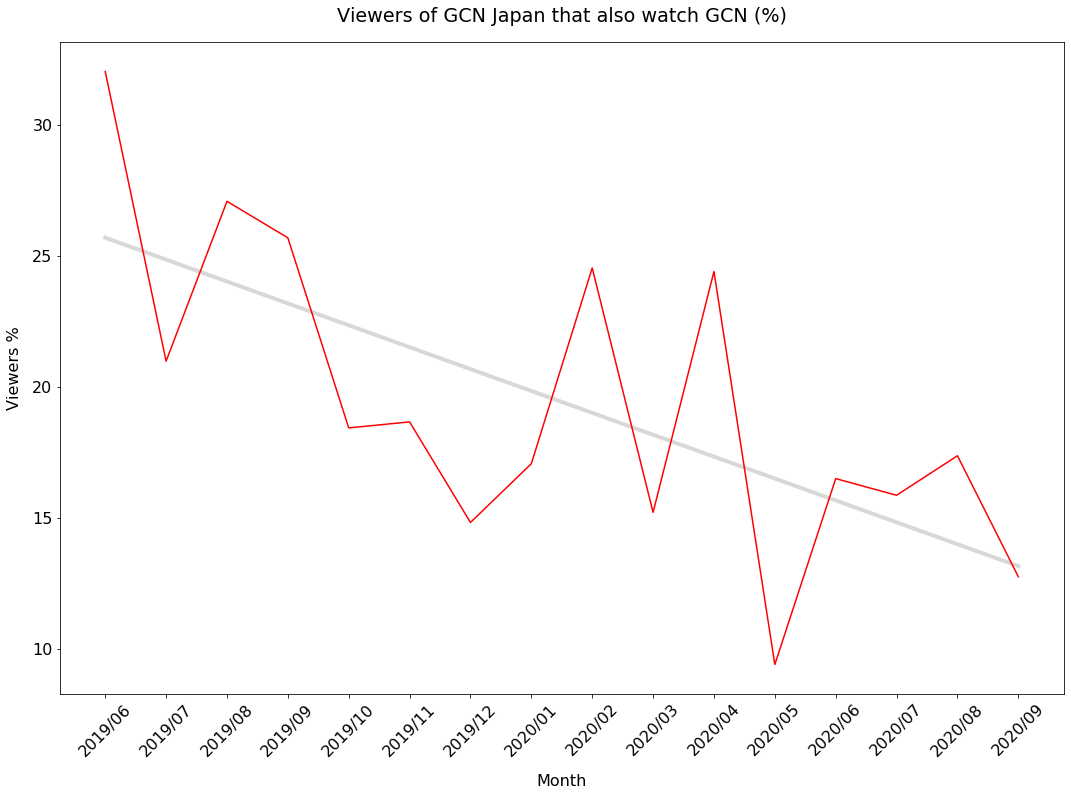

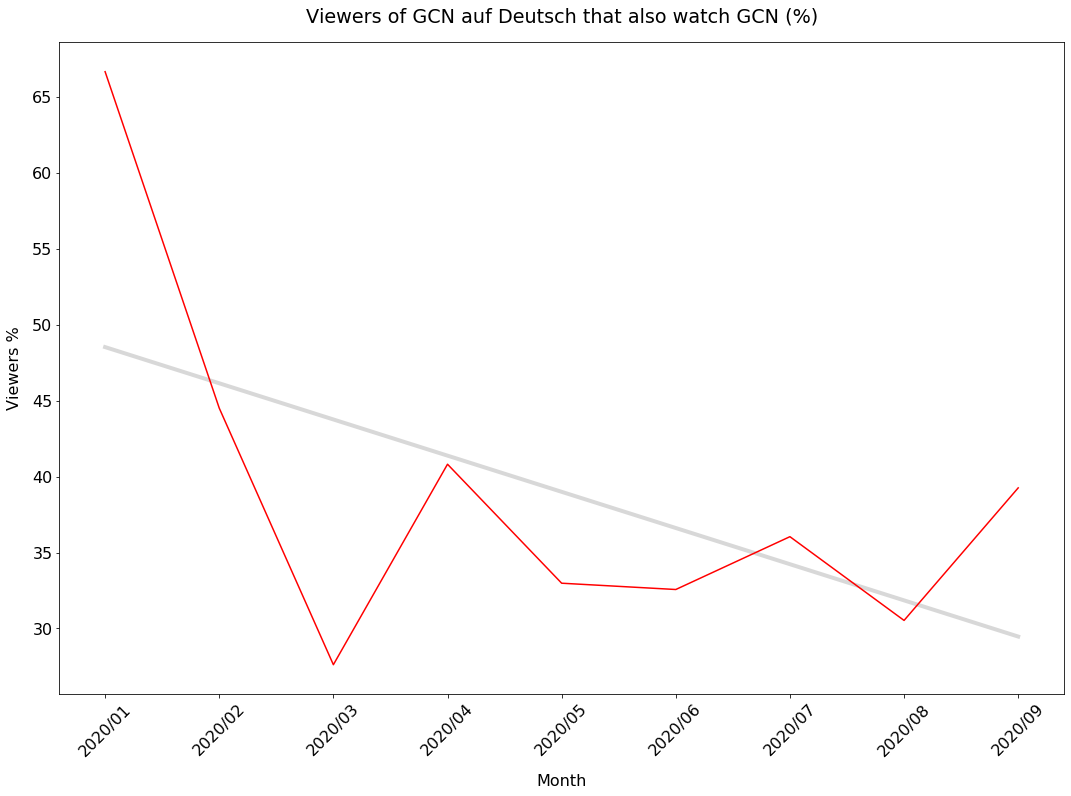

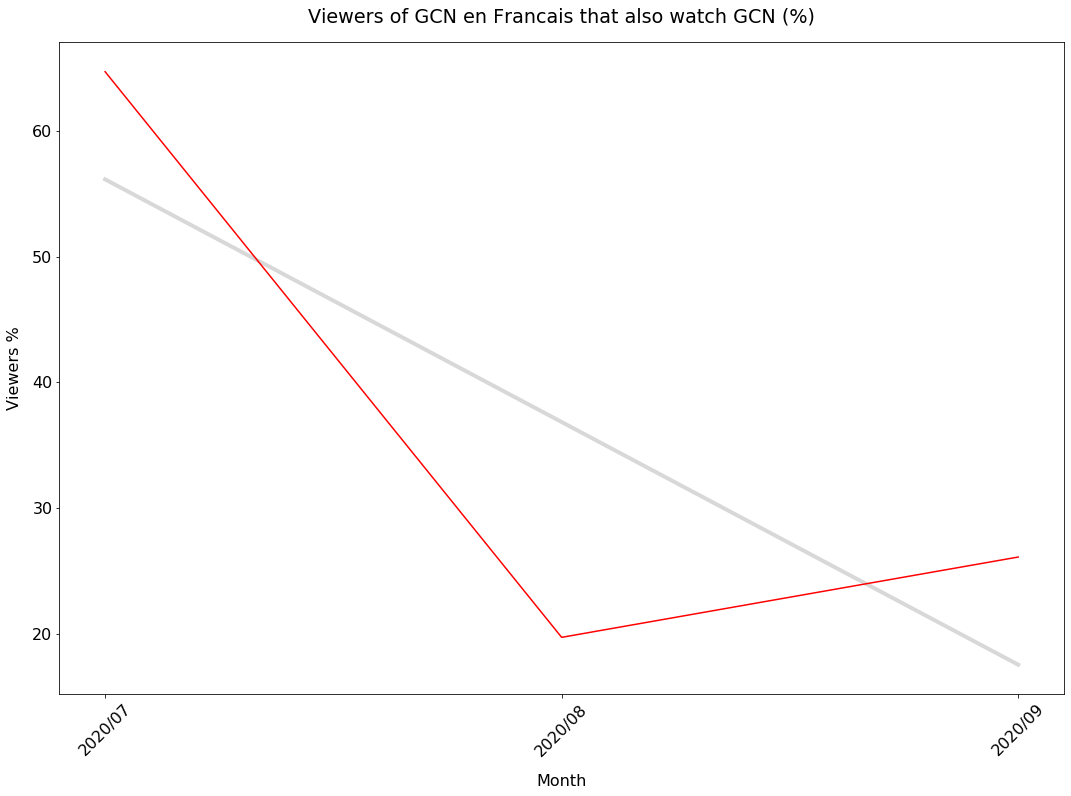

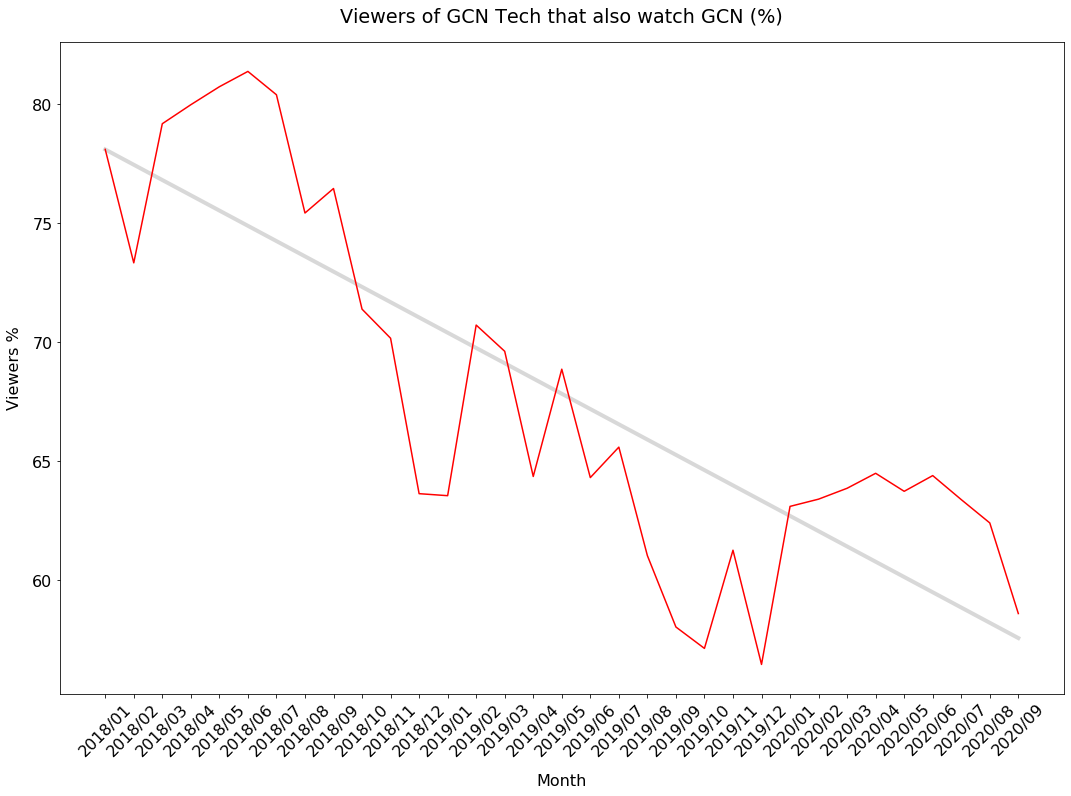

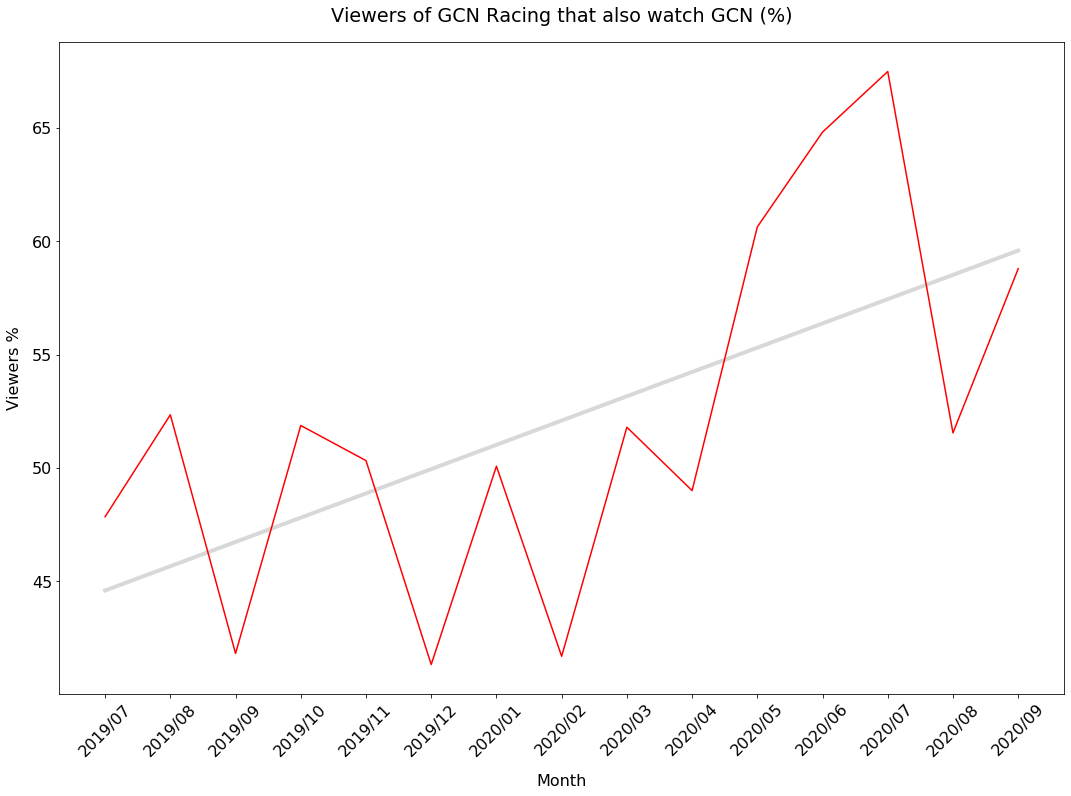

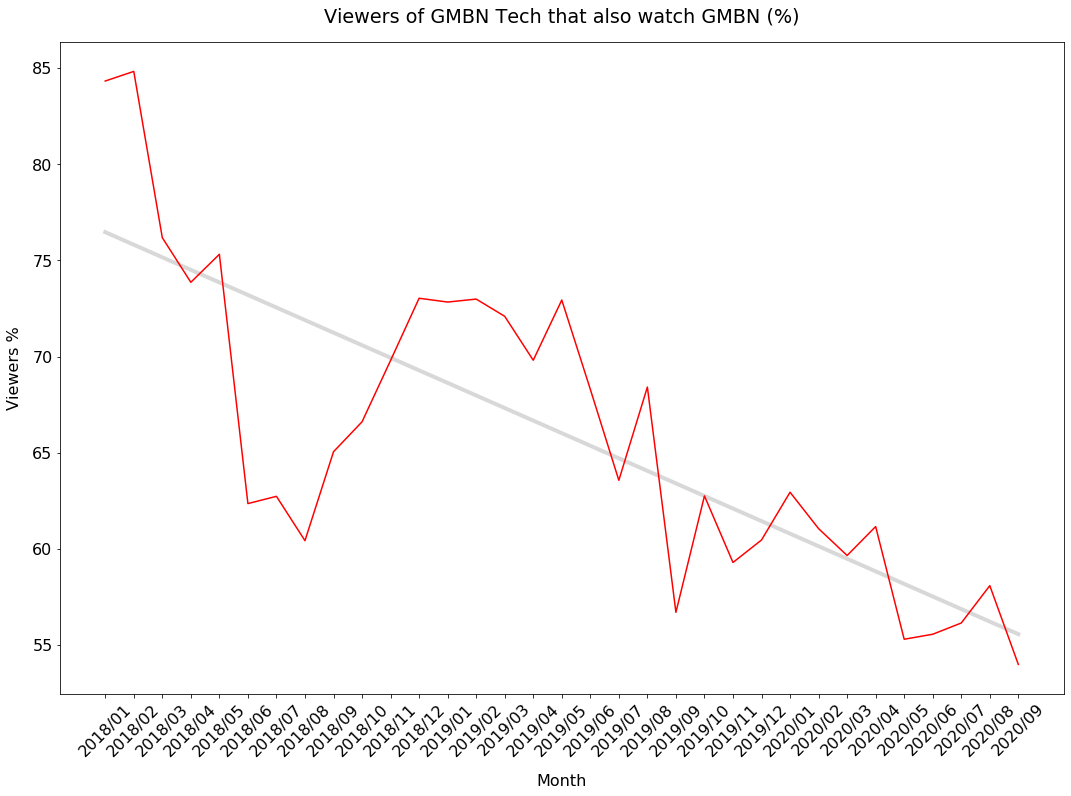

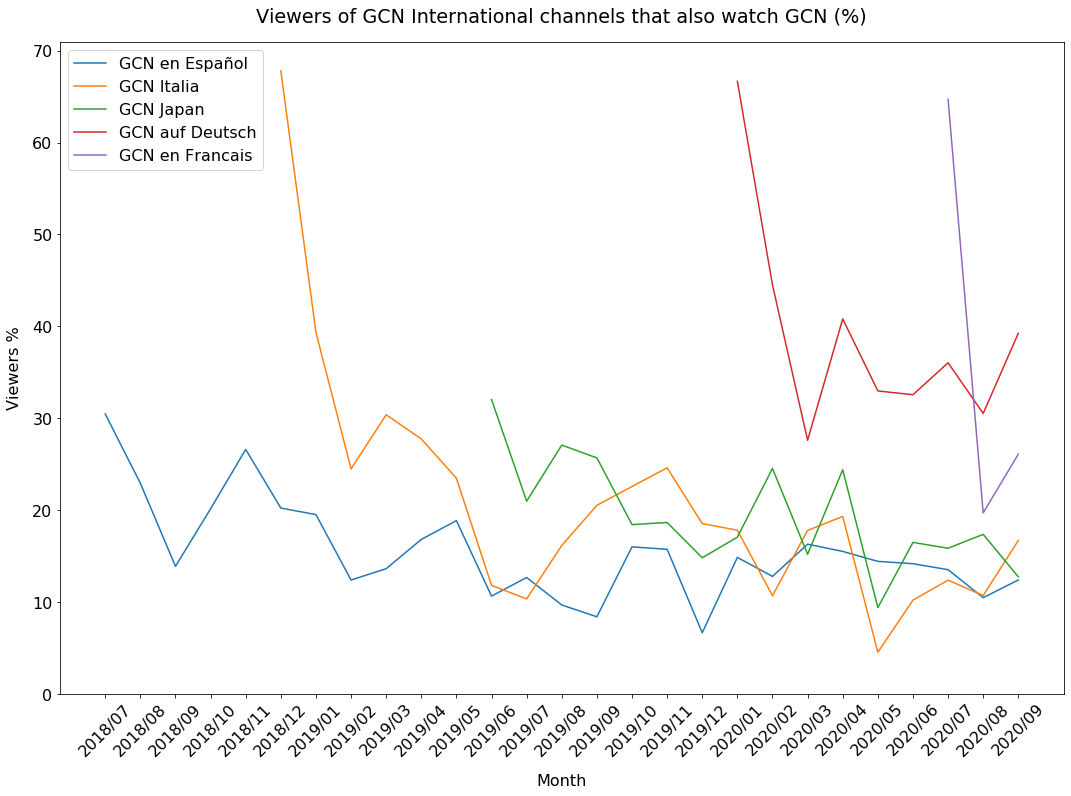

In [7]:
gcn_gcnesp = format_csv_of_string("/Users/thomas.schafer/Documents/Jupyter notebooks/Channels viewers CSV data/gcn_gcnesp.csv", True)
gcn_gcnitalia = format_csv_of_string("/Users/thomas.schafer/Documents/Jupyter notebooks/Channels viewers CSV data/gcn_gcnit.csv", True)
gcn_gcnjapan = format_csv_of_string("/Users/thomas.schafer/Documents/Jupyter notebooks/Channels viewers CSV data/gcn_gcnjapan.csv", True)
gcn_gcnaufd = format_csv_of_string("/Users/thomas.schafer/Documents/Jupyter notebooks/Channels viewers CSV data/gcn_gcnaufd.csv", True)
gcn_gcnfra = format_csv_of_string("/Users/thomas.schafer/Documents/Jupyter notebooks/Channels viewers CSV data/gcn_gcnfra.csv", True)
gcn_gcntech = format_csv_of_string("/Users/thomas.schafer/Documents/Jupyter notebooks/Channels viewers CSV data/gcn_gcntech.csv", True)
gcn_gcnrac = format_csv_of_string("/Users/thomas.schafer/Documents/Jupyter notebooks/Channels viewers CSV data/gcn_gcnracing.csv", True)
gmbn_gmbntech = format_csv_of_string("/Users/thomas.schafer/Documents/Jupyter notebooks/Channels viewers CSV data/gmbn_gmbntech.csv", True)

df_esp = time_series_plot(gcn_gcnesp, "GCN", "GCN en Español", 2018, 7, 2020, 9)
df_it = time_series_plot(gcn_gcnitalia, "GCN", "GCN Italia", 2018, 12, 2020, 9)
df_ja = time_series_plot(gcn_gcnjapan, "GCN", "GCN Japan", 2019, 6, 2020, 9)
df_ad = time_series_plot(gcn_gcnaufd, "GCN", "GCN auf Deutsch", 2020, 1, 2020, 9)
df_fr = time_series_plot(gcn_gcnfra, "GCN", "GCN en Francais", 2020, 7, 2020, 9)
df_gcn_tech = time_series_plot(gcn_gcntech, "GCN", "GCN Tech", 2018, 1, 2020, 9)
df_gcn_racing = time_series_plot(gcn_gcnrac, "GCN", "GCN Racing", 2019, 7, 2020, 9)
df_gmbn_tech = time_series_plot(gmbn_gmbntech, "GMBN", "GMBN Tech", 2018, 1, 2020, 9)

df_all_channels = pd.merge(df_esp, df_it, 'left', on='Month')
df_all_channels = pd.merge(df_all_channels, df_ja, 'left', on='Month')
df_all_channels = pd.merge(df_all_channels, df_ad, 'left', on='Month')
df_all_channels = pd.merge(df_all_channels, df_fr, 'left', on='Month')
df_all_channels.columns = [df_all_channels.columns[0]] + [n.split('(')[-1][:-1] for n in df_all_channels.columns[1:]]

df_cols = df_all_channels.columns
fig, ax = plt.subplots(figsize=(18, 12))

for i in range(1, len(df_cols)):
    line = ax.plot(df_all_channels[df_cols[0]], df_all_channels[df_cols[i]], label=df_cols[i])

ax.set_ylim(ymin=0)
ax.set_title(f'Viewers of GCN International channels that also watch GCN (%)', pad=20)
ax.set_xlabel("Month", labelpad=15)
ax.set_ylabel("Viewers %", labelpad=10)
plt.xticks(rotation=45)
ax.legend()

plt.show()

### Unique GCN en Francais viewers vs viewers from GCN

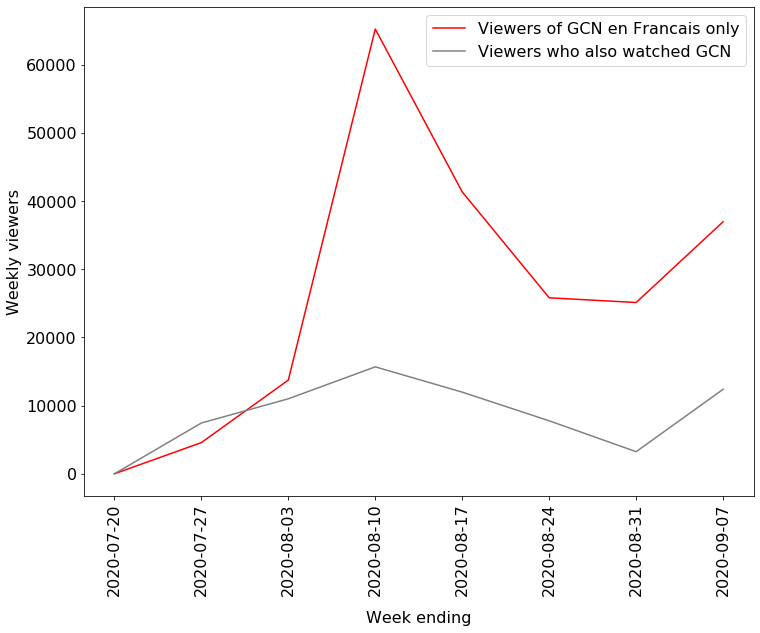

,GCN en Francais,GCN,Union,Intersection,GCN EF Only,GCN EF Only proportion
2020-07-20,0,0,0,0,0,NaN
2020-07-27,12026,1465191,1469768,7449,4577,0.380592
2020-08-03,24756,1469233,1482983,11006,13750,0.555421
2020-08-10,80933,1474292,1539535,15690,65243,0.806136
2020-08-17,53334,1558949,1600302,11981,41353,0.775359
2020-08-24,33594,1411153,1436971,7776,25818,0.768530
2020-08-31,28373,1350804,1375933,3244,25129,0.885666
2020-09-07,49376,1424039,1461016,12399,36977,0.748886


In [8]:
gcn_and_en_francais = [[0,0,0],
                       [12026, 1465191, 1469768],
                       [24756, 1469233, 1482983],
                       [80933, 1474292, 1539535],
                       [53334, 1558949, 1600302],
                       [33594, 1411153, 1436971],
                       [28373, 1350804, 1375933],
                       [49376, 1424039, 1461016],
                      ]
start_date = "2020/07/20"
days_between_data = 7

df_gcn_and_en_francais = pd.DataFrame(gcn_and_en_francais,
                                      columns=["GCN en Francais", "GCN", "Union"],

                                      index = pd.date_range(start_date, periods=len(gcn_and_en_francais)*days_between_data)[::7])
df_gcn_and_en_francais["Intersection"] = (df_gcn_and_en_francais["GCN en Francais"]
                                            + df_gcn_and_en_francais["GCN"]
                                            - df_gcn_and_en_francais["Union"]
                                         )

df_gcn_and_en_francais["GCN EF Only"] = (df_gcn_and_en_francais["GCN en Francais"]
                                            - df_gcn_and_en_francais["Intersection"]
                                         )

df_gcn_and_en_francais["GCN EF Only proportion"] = df_gcn_and_en_francais["GCN EF Only"]/df_gcn_and_en_francais["GCN en Francais"]


plt.figure(figsize=(12,9))
plt.ylabel("Weekly viewers")
plt.xlabel("Week ending", labelpad=15)

p_ef = plt.plot(df_gcn_and_en_francais.index, df_gcn_and_en_francais.iloc[:, 4], color='red')
p_int = plt.plot(df_gcn_and_en_francais.index, df_gcn_and_en_francais.iloc[:, 3],
#                 bottom=df_gcn_and_en_francais.iloc[:, 4],
                 color='grey')
plt.legend((p_ef[0], p_int[0]), ("Viewers of GCN en Francais only", "Viewers who also watched GCN"))
plt.xticks(df_gcn_and_en_francais.index, rotation=90)
plt.show()
df_gcn_and_en_francais